# Funcionalidad principal de [banrep][pypi_banrep]
[pypi_banrep]: https://pypi.org/project/banrep/

Este ejemplo muestra las funciones y clases principales de la librería.

En su uso contidiano no necesariemente toda la funcionalidad de la librería se usaría simultáneamente. Por ejemplo, cuando el interés principal es identificar tópicos en un grupo de documentos, el uso de listas de palabras y expresiones (explicadas abajo) no es indispensable.

En la sección *Requerimientos* se especifica qué funciones y clases de la librería se mostrarán.

## Requerimientos

### Importamos las otras librerías utilizadas en este ejemplo

In [1]:
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.offline as pyo
import spacy

### Y lo que usaremos de la librería [banrep][pypi_banrep]
[pypi_banrep]: https://pypi.org/project/banrep/

In [2]:
from banrep.corpus import MiCorpus
from banrep.io import Textos, leer_palabras
from banrep.topicos import Topicos
from banrep.utils import crear_directorio

### Necesitamos un modelo NLP para español de [spaCy][spacy_models]
[spacy_models]: https://spacy.io/models

Un modelo de spaCy es el que permite "tokenizar" el texto en frases y palabras, identificar categorías gramaticales de las palabras, agregar metadata, identificar "Named Entities", entre otros.

In [3]:
nlp = spacy.load('es_core_news_md')

## Cargar listas de palabras y expresiones

A lo largo de un análisis de textos se suele requerir identificar palabras o expresiones presentes en ellos, bien sea para excluirlas del análisis (ej. *stopwords*), o porque su conteo es útil para generar indicadores (ej. *indicadores de sentimiento*), o porque el análisis se quiere limitar a estudiar aquellos textos que tienen cierto tipo de contenido (ej. *expresiones relacionadas con política económica*).

### Centralizar por proyecto

En cada proyecto se va a querer tener la flexibilidad para personalizar las palabras y expresiones que se quiere identificar. Para esto se recomienda usar hojas de excel, donde cada hoja puede contener categorías de palabras o expresiones. No es necesario usar un mismo archivo excel, pero facilita tener dichas listas de palabras centralizadas para abrir un solo archivo.

#### Uso de función: `leer_palabras`

Para este ejemplo se quiere identificar (a) palabras *stopwords*, (b) palabras que identifican categorías de *sentimiento*, y (c) frases relacionadas con *incertidumbre en política económica*. Estas están en un archivo excel en las hojas `es_stops`, `es_emocion` y `es_epu` respectivamente.

Parámetros `archivo` y `hoja` determinan el archivo excel en disco, y la hoja a usar. (`rutalistas` es, en este caso, una variable que se pasa como argumento al parámetro `archivo`)

Parámetro `col_grupo` es el nombre de una columna en la hoja excel que determina el grupo al que pertenecen las palabras.

Parámetro `col_palabras` es el nombre de una columna en la hoja excel que contiene las palabras.

**Nota:** *Dado que estamos iterando un mismo archivo, este ejemplo asume que las columnas relevantes tienen el mismo nombre en cada hoja.*

In [4]:
rutalistas = '~/Dropbox/datasets/wordlists/banrep.xlsx'
listas = dict()

hojas = ['es_stops', 'es_emocion', 'es_epu']
for hoja in hojas:
    listas[hoja] = leer_palabras(rutalistas, hoja, 
                                 col_grupo='type', col_palabras='word')

### Stopwords

Generalmente se quiere ignorar palabras comunes a todos los textos, llamadas *stopwords*, por no aportar al entendimiento de los diferentes textos.

In [5]:
stopwords = listas['es_stops'].get("stopword")

print(f'{len(stopwords)} palabras stopwords.')

821 palabras stopwords.


#### Ejemplo de stopwords en excel

![](img/stopwords.png)

### Pertenencia a listas de palabras predefinidas

Muchas veces se quiere contabilizar cuantas palabras de cada documento hacen parte de listas de palabras predefinidas. Por ejemplo, puedo tener listas de palabras "positivas" y "negativas", y querer contar cuantas palabras de los textos que voy a analizar hacen parte de estas listas. Esto sirve, por ejemplo, para crear indicadores de sentimiento basados en el conteo de palabras que pertenecen a emociones "contrarias".

In [6]:
hoja = 'es_emocion'
wordlists = listas[hoja]

for tipo in wordlists:
    print(f'{len(wordlists.get(tipo))} palabras en grupo {tipo} de hoja {hoja}')

1899 palabras en grupo deterioro de hoja es_emocion
359 palabras en grupo mejora de hoja es_emocion


#### Ejemplo de emociones en excel

![](img/emocion.png)

### Pertenencia a listas de expresiones predefinidas

Al igual que con listas de palabras, a veces se quiere identificar frases de los textos en las que hay presencia de ciertas expresiones. Por ejemplo, un índice reconocido es el [Economic Uncertainty Index][epu], cuyos resultados se basan en el conteo de noticias en las que se encuentren diferentes expresiones relacionadas con incertidumbre en política económica. Por ejemplo, puedo querer identificar expresiones como *Banco de la República*, *déficit fiscal*, *política monetaria*, *inflación de alimentos*, *incertidumbre tributaria*, etc.

Identificar estas expresiones sirve también para proyectos en los que se quiere crear un [training set][prodigy] para entrenar un modelo de clasificación basado en *aprendizaje de máquina*, dado que el primer paso para dichos modelos es anotar una serie de frases que sean relevantes para lo que se quiere entrenar.


[epu]: http://www.policyuncertainty.com/research.html
[prodigy]: https://prodi.gy/

In [7]:
hoja = 'es_epu'
express = listas[hoja]

for tipo in express:
    print(f'{len(express.get(tipo))} expresiones en grupo {tipo} de hoja {hoja}')

1 expresiones en grupo colombia de hoja es_epu
16 expresiones en grupo economic de hoja es_epu
80 expresiones en grupo policy de hoja es_epu
2 expresiones en grupo uncertainty de hoja es_epu


#### Ejemplo de expresiones en excel

![](img/epu.png)

## Preprocesamiento de texto y filtros

### Textos a usar

Se asume una carpeta en disco en la que hay archivos de texto. Si los textos que quiere utilizar están en archivos binarios como *.pdf*, *.docx*, etc., debe primero [extraer el texto][extraccion].

[extraccion]: https://munozbravo.github.io/banrep/uso_extraccion/

#### Uso de clase: `Textos`

Se usa para iterar los archivos de texto en disco.

Argumento `rutadatos` especifica ubicación de los textos en disco (parámetro `directorio`).

Parámetro `chars` filtra aquellas líneas de texto de cada archivo cuya longitud sea inferior al valor especificado. *69* es valor arbitrario que permite filtrar la mayoría de títulos y subtítulos.

Parámetro `parrafos` permite definir si se considera cada párrafo como un documento separado.

Parámetro `aleatorio` sirve cuando se quiere iterar los archivos aleatoriamente.

In [8]:
rutadatos = '../datasets/'

datos = Textos(rutadatos, aleatorio=False, chars=69, parrafos=True, 
               recursivo=True, exts=['.txt'])
print(datos)

29 archivos en directorio datasets.


### Filtros: palabras y tokens a ignorar

Se obtendrá información detallada de cada palabra gracias a [spaCy][web_spacy], lo que permite filtrar adicionalmente por criterios como [categoría gramatical][universal] (verbos, sustantivos, etc), si es algún tipo de [nombre propio][spacy_ents] (Juan, Colombia, Banco de la República), si contiene caracteres que no hacen parte del alfabeto (números, monedas, etc), o si no supera una longitud mínima. 

[web_spacy]: https://spacy.io/
[universal]: https://universaldependencies.org/es/index.html
[spacy_ents]: https://spacy.io/api/annotation#named-entities

En este caso elimino de cualquier análisis posterior todas las *stopwords* del archivo excel, las categorías gramaticales que identifican números, puntuación y símbolos, y aquellas "palabras" o tokens que contengan caracteres que no hacen parte del alfabeto. También elimino palabras que no tengan más de dos caracteres.

In [9]:
tags = ['NUM', 'PUNCT', 'SYM']

filtros = dict(stopwords=stopwords, postags=tags, entities=None, is_alpha=True, chars=2)

## Corpus y sus estadísticas

### Crear el corpus

Un *corpus* es un conjunto de documentos, para el cual queremos obtener toda clase de estadísticas.

`MiCorpus` es la implementación de un corpus, el cual se inicializa con un modelo [spaCy][spacy_models] y un objeto `Textos`, y opcionalmente con los filtros especificados anteriormente, las listas de palabras que se quiere contar, y expresiones que se quiere encontrar. 

[spacy_models]: https://spacy.io/models

#### Uso de clase: `MiCorpus`

Se usa para inicializar el corpus. Es la estructura más importante de [banrep][pypi_banrep].

Argumento `nlp` es el modelo spaCy (parámetro `lang`).

Parámetro `datos` es el objeto Textos creado anteriormente en la variable *datos*.

Parámetros `filtros`, `wordlists` y `express` ya explicados anteriormente.

Parámetro `corta` sirve como filtro adicional, ignorando frases de pocos tokens (palabras, puntuación, símbolos, números, etc. En este ejemplo, frases con menos de 10 tokens).

Parámetro `no_above` deja de considerar palabras que aparezcan en más de un porcentaje de documentos. Esto porque palabras repetidas en muchos documentos no suelen aportar mucho a su entendimiento, y dichas palabras pueden no estar consideradas en los *stopwords*. **Este parámetro solo afecta la creación de modelos de tópicos**.

[pypi_banrep]: https://pypi.org/project/banrep/

In [10]:
corpus = MiCorpus(nlp, datos, filtros=filtros, 
                  wordlists=wordlists, express=express, 
                  corta=9, no_above=0.75,)
print(corpus)

5628 docs procesados...
Modelo de n-gramas ha sido creado...
Diccionario con 3613 términos creado...
Corpus: 5628 docs y 3613 términos.


### Estadísticas de corpus agregadas

Generalmente se quiere identificar cada documento por su metadata, y por conteos agregados de sus frases y palabras. En este caso el conteo se limita a las frases y palabras que cumplen con los filtros explicados anteriormente.

In [11]:
stats = corpus.corpus_stats()
stats.tail()

,doc_id,archivo,fuente,ok_span,ok_token,deterioro,mejora,colombia,economic,policy,uncertainty
5623,005624,2005-12.txt,inflacion,1,7,0,0,False,False,False,False
5624,005625,2005-12.txt,inflacion,2,16,1,0,False,False,False,True
5625,005626,2005-12.txt,inflacion,3,46,1,1,False,True,True,False
5626,005627,2005-12.txt,inflacion,3,60,2,0,False,True,True,True
5627,005628,2005-12.txt,inflacion,2,26,0,0,False,False,True,False


### Estadísticas desagregadas por token

Muchas veces el acceso a las palabras desagregadas es deseado, por ejemplo para contar las palabras más frecuentes en un documento o en el corpus, o para limitar el conteo a palabras que hacen parte de una categoría gramatical específica (ej. sustantivos, verbos). También es relevante para el cálculo de indicadores de sentimiento que se basan en conteos de palabras con diferentes tipos de "emociones".

El método `corpus_tokens` ofrece este tipo de funcionalidad.

El método `corpus_ngramed` identifica también aquellos "tokens" compuestos por múltiples palabras que co-ocurren frecuentemente.

In [12]:
tokens = corpus.corpus_tokens()
tokens.tail()

,doc_id,sent_id,tok_id,word,pos,ok_token,deterioro,mejora
173775,005628,2,12,esquema,NOUN,True,False,False
173776,005628,2,13,intervención,NOUN,True,False,False
173777,005628,2,14,discrecional,ADJ,True,False,False
173778,005628,2,15,mercado,NOUN,True,False,False
173779,005628,2,16,cambiario,ADJ,True,False,False


In [13]:
con_ngrams = corpus.corpus_ngramed()
con_ngrams.head(10)

,doc_id,sent_id,tok_id,word
0,000001,1,1,términos
1,000001,1,2,referencia
2,000001,1,3,decisiones
3,000001,1,4,política_monetaria
4,000001,1,5,junta_directiva_banco_república
5,000001,1,6,periódicamente
6,000001,1,7,análisis
7,000001,1,8,detallado
8,000001,1,9,resultados
9,000001,1,10,inflación


### Estadísticas desagregadas por frase

Con frecuencia se quiere identificar el texto de cada frase y sus estadísticas asociadas.

Si se ha querido encontrar expresiones, por ejemplo, generalmente se debe a que se quiere contar cuantas frases o documentos contienen dichas expresiones, para crear algún indicador a partir de dicho conteo.

También su usa cuando se piensa adelantar un proyecto de aprendizaje de máquina supervisado, en el que se requiere manualmente "clasificar" cada frase relevante.

**Nota**: El uso de este método sobre-escribe los [entities][ner] del modelo NLP, para reemplazarlos por las expresiones que se quiera encontrar. Esto, en el caso que se pasen expresiones a `MiCorpus` usando el parámetro `express`.

[ner]: https://spacy.io/usage/spacy-101#annotations-ner

In [14]:
stats_frases = corpus.frases_stats()
stats_frases.head(10)

,doc_id,sent_id,frase,ok_span,ok_token,deterioro,mejora,colombia,economic,policy,uncertainty
0,000001,1,Con el fin de tener unos términos de referenci...,True,18,0,0,False,True,True,False
1,000002,1,"La Junta ha decidido, a partir de ahora, hacer...",True,17,0,0,False,False,True,False
2,000003,1,La publicación de un Informe sobre la Inflació...,True,17,0,0,False,False,False,False
3,000003,2,"Así mismo, sirve para comunicar a la opinión p...",True,9,0,0,False,False,False,False
4,000004,1,Esta publicación también responde a la importa...,True,13,0,0,False,False,False,False
5,000005,1,El informe incluye una sección que analiza det...,True,8,0,0,False,False,False,False
6,000005,2,"En los próximos informes, en lo relacionado co...",True,7,0,0,False,False,False,False
7,000005,3,La segunda sección describe el comportamiento ...,True,15,0,0,False,False,True,False
8,000005,4,En la tercera sección se presentan las expecta...,True,10,0,0,False,False,True,False
9,000005,5,La cuarta sección presenta proyecciones de la ...,True,18,0,1,False,False,True,False


## Modelos de tópicos y su visualización

### Crear modelos LDA

Los modelos de tópicos se usan para encontrar "temáticas" subyacentes en los textos.

El parámetro básico a especificar en un modelo es el número de tópicos que se quiere considerar en el resultado.

Esta librería usa [Gensim][web_gensim] para la implementación del cálculo de los modelos. En su [documentación][gensim_tuts] encontrará todo lo necesario para correr este tipo de modelos y muchas técnicas adicionales no usadas en esta librería. [banrep][pypi_banrep] simplemente ofrece funciones para correr varios modelos LDA y seleccionar el mejor, todo basado en Gensim.

[web_gensim]: https://radimrehurek.com/gensim/models/ldamodel.html
[gensim_tuts]: https://radimrehurek.com/gensim/tutorial.html
[pypi_banrep]: https://pypi.org/project/banrep/

#### Uso de clase: `Topicos`

Se usa para crear modelos lda para diferentes números de tópicos.

Argumento `corpus` es una instancia de `MiCorpus`, y `n_topicos` es una lista de números para los cuales se quiere generar un modelo.

Parámetro `params` es un diccionario con parámetros que se usan en la [implementación LDA de Gensim][lda_gensim] (gensim.models.ldamodel.LdaModel).

Los modelos de tópicos suelen ser evaluados usando una medida llamada *Coherence Score*. Esta medida sugiere qué tan "interpretables" son los modelos. Un mayor score es un modelo más "interpretable", y por lo tanto mejor.

`Topicos` permite acceso a todos los modelos generados, y el mejor según Coherence Score se puede seleccionar usando el método `mejor_modelo`.  

[lda_gensim]: https://radimrehurek.com/gensim/models/ldamodel.html

In [15]:
n_topicos = (5, 10, 15)
params = dict(passes=2, alpha='auto', eta='auto', random_state=100)

topicos = Topicos(corpus, n_topicos, params)
print(topicos)

Modelos LDA para valores k en (5, 10, 15): mejor k=15 (Coherence=0.4213)


In [16]:
modelo = topicos.mejor_modelo()

### Visualización PyLDAvis (opcional)

En análisis de tópicos se suele usar PyLDAvis para visualizar resultados de un modelo.

La visualización es muy útil para entender la diferencia entre tópicos (distancia entre los círculos de la gráfica en costado izquierdo), prevalencia de cada tópico (tamaño de cada círculo), y el contenido de cada tópico (palabras más probables desplegadas en costado derecho para cada círculo).

El único "*pero*" es que suele generar advertencias de uso "obsoleto" (DeprecationWarning).

In [17]:
import warnings

import pyLDAvis
import pyLDAvis.gensim

# Gráfica LDAvis de tópicos y sus palabras
bow = list(corpus)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    vis = pyLDAvis.gensim.prepare(modelo, bow, corpus.id2word, sort_topics=False)

In [18]:
pyLDAvis.display(vis)

### Alternativa a PyLDAvis (opcional)

Para entender diferencia entre tópicos también se puede usar un *heatmap*, en el que cada celda representa la "distancia" entre dos tópicos. 

Este, unido a las *Estadísticas de Modelo de tópicos* mencionadas abajo, provee la misma información que PyLDAvis.

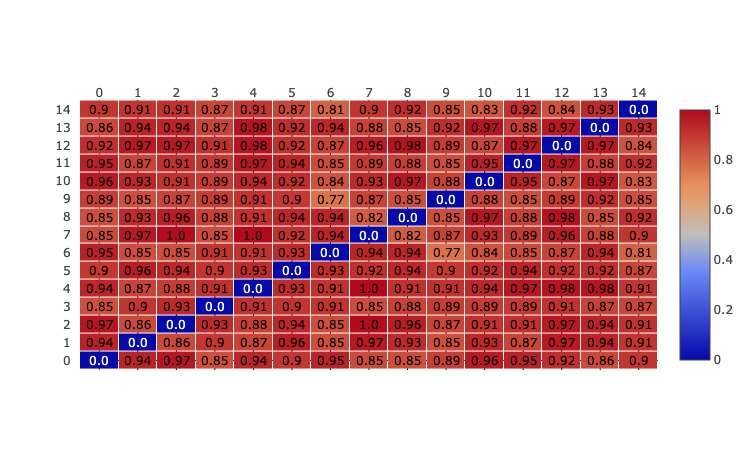

In [19]:
import plotly.figure_factory as ff

k = modelo.num_topics
diferencia, notas = modelo.diff(modelo, distance="hellinger", annotation=False)
anno_text = np.around(diferencia, decimals=2)

fig = ff.create_annotated_heatmap(z=diferencia, annotation_text=anno_text, 
                                  x=list(range(k)), y=list(range(k)), xgap=1, ygap=1,
                                  showscale=True, 
                                  )

pyo.iplot(fig)

## Estadísticas de Modelo de tópicos

### Distribución de probabilidad de palabras en cada tópico

Un tópico no es más que una serie de palabras con cierta probabilidad de ocurrir. Las palabras con mayor probabilidad son las que permiten "caracterizar" un tópico. 

#### Uso de método: `palabras_probables`

Genera un DataFrame con las palabras más probables de cada tópico en un modelo.

Parámetro `modelo` es un modelo LDA y `n` indica cuantas palabras se quiere incuir en el resultado.

In [20]:
palabras = topicos.palabras_probables(modelo, n=20)

In [21]:
palabras.head(10)

,palabra,probabilidad,topico
0,inflación,0.042729,0
1,pronóstico,0.032671,0
2,pronósticos,0.021568,0
3,promedio,0.014640,0
4,modelos,0.010583,0
5,nivel,0.010268,0
6,banco,0.007722,0
7,probabilidad,0.007671,0
8,devaluación,0.006915,0
9,tasa_desempleo,0.006803,0


#### Visualización de palabras con gráficas de barras (opcional)

Visualizar las palabras más probables de cada tópico sirve para "ponerle nombre" a cada tópico.

Aunque esta información es fácilmente visible en `PyLDAvis`, estas son otras opciones.

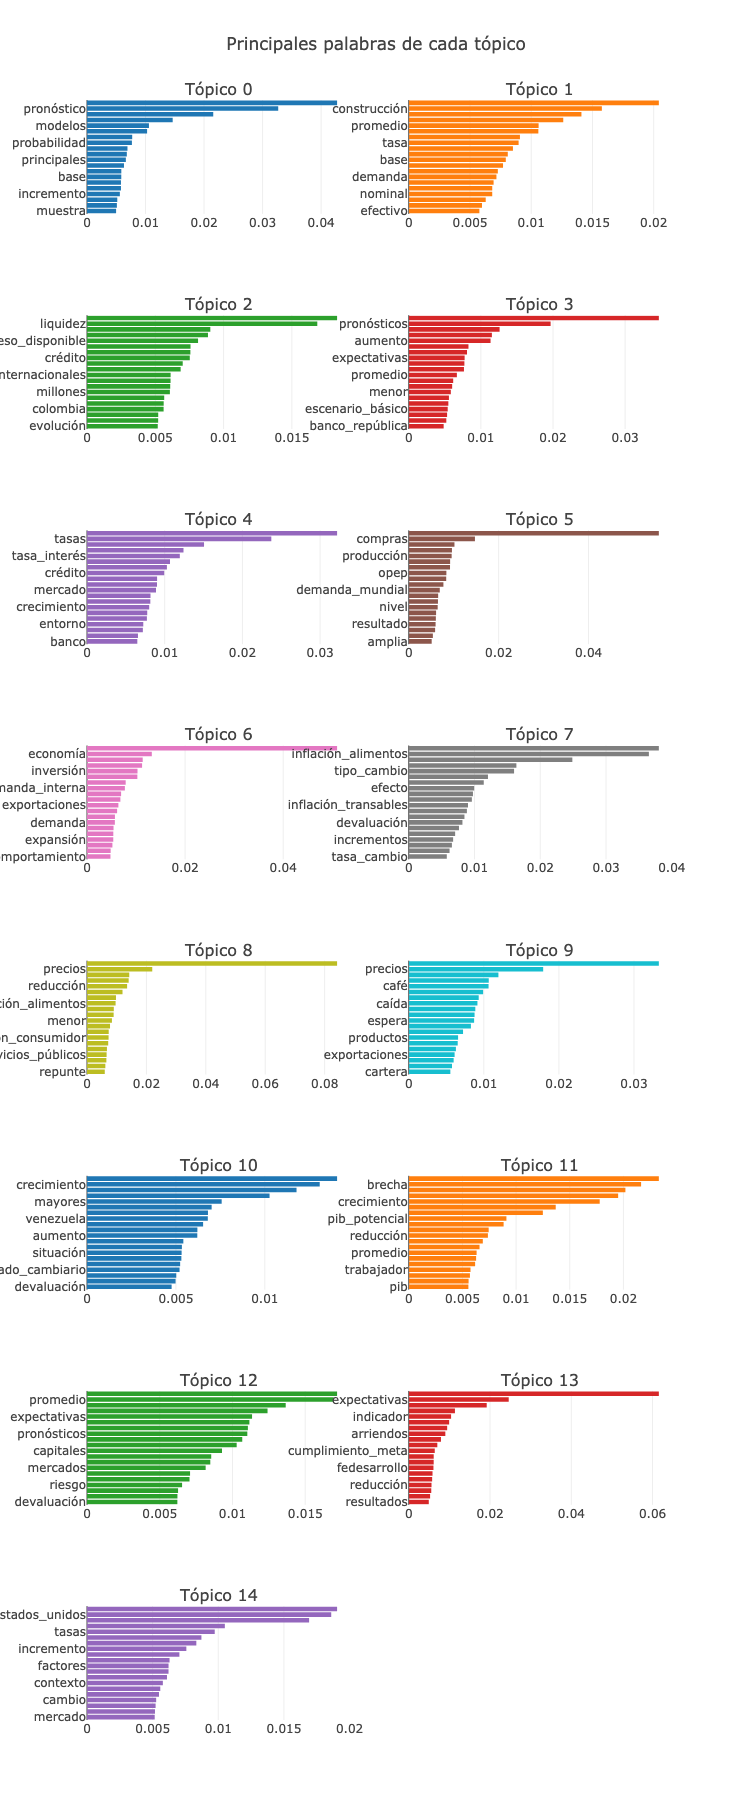

In [22]:
from plotly import tools
import plotly.graph_objs as go

k = modelo.num_topics
cols = 2
rows = int(np.ceil(k / cols))

subi = [(r+1, c+1) for r in range(rows) for c in range(cols)]

fig = tools.make_subplots(rows=rows, cols=cols, 
                          subplot_titles=([f'Tópico {t}' for t in range(k)]),
                          print_grid=False,
                         )

for i, t in enumerate(range(k)):
    dfg=palabras.loc[palabras['topico'] == t]
    dfg.sort_values(by='probabilidad', inplace=True)
    
    trace = go.Bar(x=dfg['probabilidad'], y=dfg['palabra'], orientation='h',)
    
    ix = subi[i]
    fig.add_trace(trace, row=ix[0], col=ix[1])

fig.layout.update(title='Principales palabras de cada tópico',
                  showlegend=False, yaxis=dict(automargin=True, ),
                  height=1800, width=1000)

pyo.iplot(fig)

#### Nubes de palabras (opcional)

Las nubes de palabra realmente no ofrecen valor adicional por encima de un gráfico de barras tradicional. Pero si le insisten que por favor genere nubes de palabras bonitas pero inútiles, esta sería una forma de hacerlo.

**Nota:** *Para controlar el tipo de letra puede buscar en internet uno que le guste. Este ejemplo usa [CabinSketch descargado de FONT Squirrel][cabin].*

[cabin]: https://www.fontsquirrel.com/fonts/cabinsketch

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc_params =dict(font_path="~/Dropbox/datasets/fonts/cabinsketch/CabinSketch-Bold.otf", 
                width=800, height=400, prefer_horizontal=0.6, background_color='white')

figwc = plt.figure(figsize=(16, 12))
figwc.subplots_adjust(hspace=0.05, wspace=0.1)

for t in range(k):
    freq = dict(modelo.show_topic(t, topn=20))
    wc = WordCloud(**wc_params).generate_from_frequencies(freq)

    plt.subplot(rows, cols, t+1).set_title(f"Tópico {t}")
    plt.plot()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

plt.tight_layout()
plt.savefig('img/nubes.png')

![](img/nubes.png)

### Distribución de probabilidad de tópicos en documentos

Usualmente se quiere ver la probabilidad de cada tópico asociada a cada documento. Se puede  pensar un documento como generado de una distribución de probabilidad de tópicos. 

El método `stats_topicos` devuelve dicha distribución. Para cada documento (fila) muestra la  probabilidad de que hable de cada tópico (columna).

Basado en esta distribución, el método también devuelve la "prevalencia" de cada tópico: en cuantos documentos del corpus es dominante (el de mayor probabilidad).

#### Uso de método: `stats_topicos`

Parámetro `modelo` es un modelo LDA.

In [24]:
doctopics, dominante = topicos.stats_topicos(modelo)

In [25]:
doctopics.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
005624,NaN,NaN,NaN,NaN,NaN,NaN,0.013395,0.247941,NaN,NaN,NaN,0.635955,NaN,NaN,NaN
005625,0.396938,0.264278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291679,NaN,NaN,NaN
005626,0.163084,NaN,NaN,NaN,NaN,0.111913,NaN,0.214021,NaN,NaN,NaN,NaN,NaN,0.274663,0.217645
005627,0.077764,NaN,0.025687,0.341454,0.044958,0.039232,0.047429,NaN,NaN,NaN,NaN,NaN,NaN,0.414438,NaN
005628,NaN,NaN,0.211071,NaN,0.240460,NaN,NaN,NaN,NaN,NaN,0.378843,NaN,NaN,0.134884,NaN


In [26]:
dominante.head()

topico
6     0.212
8     0.099
14    0.077
9     0.074
7     0.068
dtype: float64

### Aplicar modelo a otro corpus (opcional)

Una vez ha entrenado un modelo, puede incluso aplicárselo a otro corpus. Sólo hay que aplicarle el mismo tipo de preprocesamiento y filtros a los datos.

Por ejemplo, en este caso el modelo se entrenó por párrafo, pero puedo estar interesado en la distribución de probabilidad de tópicos *para cada archivo de texto*. 

(**En un escenario ideal, su fuente de datos es tan amplia que no necesita entrenar a nivel de párrafos. Se necesitan bastantes documentos para entrenar un modelo de tópicos**).

**Nota:** *El siguiente ejemplo usualmente se haría en otro archivo o proceso Python. Esto es porque el modelo spaCy importado al inicio ha variado al interior de `MiCorpus`. Usualmente se usa un solo modelo spaCy por proceso.*

La función `doc_topico` creada abajo es un ejemplo de cómo generar la distribución de probabilidad de tópicos por fuera de `MiCorpus`.

In [27]:
# Es en los datos donde se especifica si es por párrafos o no.
datos2 = Textos(rutadatos, aleatorio=False, chars=69, parrafos=False, 
                recursivo=True, exts=['.txt'])

# en este caso no me interesa que identifique las listas de palabras y expresiones...
nlp2 = spacy.load('es_core_news_md')
otro_corpus = MiCorpus(nlp2, datos2, filtros=filtros, 
                       ngrams=corpus.ngrams, id2word=corpus.id2word,
                       corta=9, no_above=0.75,)
print(otro_corpus)

29 docs procesados...
Corpus: 29 docs y 3613 términos.


In [28]:
def doc_topico(modelo, corpus):
    """Distribución de probabilidad de tópicos en cada documento.

    Parameters
    ----------
    modelo : gensim.models.ldamodel.LdaModel
        Modelo LDA entrenado.
    corpus : banrep.corpus.MiCorpus
        Corpus previamente inicializado con documentos.

    Returns
    -------
    pd.DataFrame
        Distribución de probabilidad de tópicos x documento.
    """
    data = (dict(doc) for doc in modelo[corpus])
    index = [doc._.get("doc_id") for doc in corpus.docs]

    return pd.DataFrame(data=data, index=index)

In [29]:
doctopics2 = doc_topico(modelo, otro_corpus)
doctopics2.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
000025,0.046553,0.019622,0.018368,0.037245,0.021918,0.053895,0.178070,0.103165,0.060647,0.076586,0.081541,0.044623,0.082912,0.065349,0.109507
000026,0.070278,NaN,0.016041,0.050703,0.025692,0.038086,0.209696,0.050319,0.033938,0.063212,0.089694,0.039338,0.078396,0.057901,0.167115
000027,0.058143,0.034985,0.034010,0.040738,0.029250,0.042540,0.206178,0.080390,0.038248,0.063900,0.058657,0.051887,0.074841,0.061181,0.125050
000028,0.071717,0.031047,0.048064,0.052548,0.022196,0.045344,0.238050,0.048289,0.048089,0.077881,0.047179,0.052929,0.059651,0.054928,0.102087
000029,0.079449,0.028434,0.031885,0.050355,0.028996,0.032334,0.220973,0.072883,0.063490,0.062517,0.054410,0.062469,0.042986,0.068428,0.100390


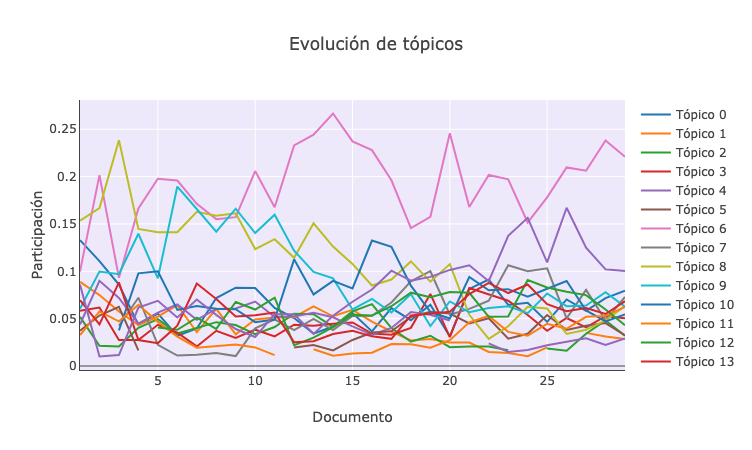

In [30]:
traces = []

for i in doctopics2.columns:
    traces.append(go.Scatter(x=doctopics2.index, y=doctopics2[i], 
                             line=dict(width=2), name=f'Tópico {i}'))

axis = dict(
    showline=True,
    zeroline=True,
    showgrid=True,
    gridcolor='#ffffff',
    automargin=True
)

layout = dict(title='Evolución de tópicos',
              xaxis=dict(axis, **dict(title='Documento')),
              yaxis=dict(axis, **dict(title='Participación', hoverformat='.2f')),
              hovermode='closest',
              plot_bgcolor='rgba(228, 222, 249, 0.65)')

fig2 = dict(data=traces, layout=layout)
pyo.iplot(fig2)

## Almacenamiento de objetos generados

### Criterios

El corpus y los modelos de tópicos generan estructuras que pueden ser útiles más adelante, y por lo tanto se quiere guardar a disco.

Se quiere usualmente almacenar modelos de "ngramas", el "diccionario" que contiene todas las palabras únicas existentes en el corpus, y el mejor modelo de tópicos opcionalmente con  su visualización.

#### Uso de función: `crear_directorio`

`crear_directorio` simplemente crea un directorio en disco, en el que se quiere guardar las estructuras generadas. En este caso se quiere crear directorio de salida para estructuras generales, y opcionalmente uno diferente para el mejor modelo.

In [31]:
# Crear directorio de salida
dirsalida = crear_directorio('topicos')

# Crear directorio para mejor modelo.
dirmodelo = crear_directorio(dirsalida.joinpath(f'{topicos.top_k:0>2}'))

### Guardar n-gramas y diccionario generados en corpus

In [32]:
#Guardar modelos de bigramas y trigramas
corpus.ngrams.get('bigrams').save(str(dirsalida.joinpath('bigrams')))
corpus.ngrams.get('trigrams').save(str(dirsalida.joinpath('trigrams')))

# Guardar diccionario
corpus.id2word.save(str(dirsalida.joinpath('id2word')))

### Guardar mejor modelo LDA y su visualización

In [33]:
modelo.save(str(dirmodelo.joinpath('topicos.lda')))
pyLDAvis.save_html(vis, str(dirmodelo.joinpath('topicos.html')))

### Guardar distribución de probabilidad de tópicos y su visualización

In [34]:
doctopics2.to_csv(str(dirsalida.joinpath('doctopics.csv')),
                 index_label='doc', encoding='utf-8')

fp_ = pyo.plot(fig2, show_link=False,
               filename=str(dirsalida.joinpath('doctopics.html')), 
               auto_open=False)

### Guardar frases y sus estadísticas

In [35]:
# Crear directorio de salida
dirstats = crear_directorio('stats')

stats_frases.to_csv(str(dirstats.joinpath('frases.csv')), 
                    index=False, encoding='utf-8')